# Classic Binomial model

Binomial model describes 
underlying with discrete time 
Markov process. 

This Markov chain is fully parametrized with: 
- $S_0 \in \mathbb{R}$: starting price 
- $u>1$: upwards multiplicative factor 
- $d<1$: downwards multiplicative factor 
- $q>1$: average increase factor 

in the following way:
<!-- - State space $\{u^{i} d^{j} S_0 | i,j \in \mathbb{N}\}$ -->
- Starting in state $S_0$ 
- Transition rule  $\forall n,i,j \in \mathbb{N}:$
$$
\begin{aligned}
P(S_{n+1} = u^{i+1} d^{j} S_0 | S_{n} = u^{i} d^{j} S_0) &= p \\
P(S_{n+1} =u^{i} d^{j+1} S_0 | S_{n} = u^{i} d^{j} S_0) &= 1-p
.
\end{aligned}
$$ 
i.e p is the probability of going upwards and can be derived:
$$
\begin{aligned}
E[S_{n+1} | S_{n}] &= q S_n \Leftrightarrow \\
p&= \frac{q-d}{u-d}
.
\end{aligned}
$$ 
With some elementary probability theory we find
$ \forall n,i \in \mathbb{N}$: 

$$
P(S_{n} =u^{i} d^{n-i} S_0) = 
\left( \begin{matrix} {{{n}}} \\ {{{i}}} \\ \end{matrix} \right) p^{i} \left( 1-p \right)^{n-i}. 
$$ 
i.e going upwards is Binomial distributed or $S_{n} = u^{X} d^{n-X} S_0$ with $X \sim \text{Bin}(n,p)$.

# Comparing to BS assumptions
We will not be doing any calibration to empirical data. Calibration 
defined as choosing model parameters such that a model behaves  
as similar as possible to the empirical data. <br>
But we will compare the Binomial model to
GBM. GBM is given by following 
SDE: 
$$
\frac{dS_{t}}{S_{t}} = r dt + \sigma dW_{t}.
$$ 
with initial condition $S_0 \in \mathbb{R}^{+}$, $r>0$ (BS)-intrest rate and $\sigma>0$ BS-volatility.
Which has known solution:
$$
S_{t}=S_{0} \operatorname{e x p} \biggl( \left( r-{\frac{\sigma^{2}} {2}} \right) t+\sigma W_{t} \biggr). 
$$
By assuming that every transition in the binomial model takes $\Delta t$ time, in the course we match 
GBM with the binomial parameters by comparing low-order terms of Taylor series in $\Delta t$:

$$
\begin{aligned}
u=&e^{\sigma\sqrt{\Delta t}} \\
d=&e^{-\sigma\sqrt{\Delta t}} \\
q=&e^{r \Delta t} \Leftrightarrow \\
p &=\frac{e^{r \Delta t}-e^{-\sigma\sqrt{\Delta t}}}{e^{\sigma\sqrt{\Delta t}}-e^{-\sigma\sqrt{\Delta t}}}
.
\end{aligned}
$$ 


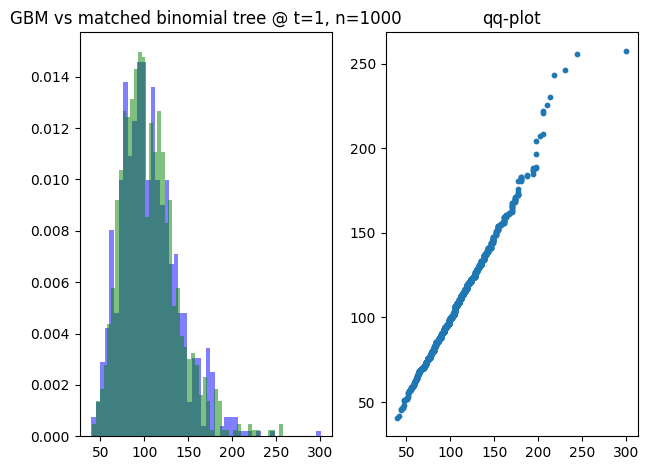

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_binomial(S0, u, d, p, n):
    """Simulate the process S_{n} = u^{X} d^{n-X} S_0 with X ~ Bin(n, p)"""
    X = np.random.binomial(n, p)
    S_n = S0 * (u ** X) * (d ** (n - X))
    return S_n

def simulate_GBM(S0, r, sigma, t):
    """Simulate the geometric Brownian motion process S_{t}=S_{0} exp((r-sigma^2/2)t + sigma*W_{t})"""
    W_t = np.random.standard_normal()
    S_t = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W_t)
    return S_t

def match_parameters(t, r, sigma, n):
    """Calculate S0, u, d, p based on t, r, sigma, and n"""
    delta_t = t / n
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)
    return  u, d, p

np.random.seed(42)
S0,r,sig,t,n = 100,0.05,0.30,1,1000
u,d,p = match_parameters(t, r, sig, n)

SSn_bin = [simulate_binomial(S0, u, d, p, n) for _ in range(1000)]
SSt_GBM = [simulate_GBM(S0, r, sig, t) for _ in range(1000)]

fig, axs = plt.subplots(1,2)
# histograms on first subplot
axs[0].hist(SSn_bin, bins=50, density=True, color="b", alpha=0.5)
axs[0].hist(SSt_GBM, bins=50, density=True, color="g", alpha=0.5)
axs[0].set_title("GBM vs matched binomial tree @ t=1, n=1000")

#qq plots on second subplot
axs[1].scatter(np.sort(SSn_bin), np.sort(SSt_GBM),alpha=1,s=10)
axs[1].set_title("qq-plot")

plt.tight_layout()
plt.show()

#  